In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model

In [2]:
test_dir = "./Dataset/test"
train_dir_final = "./Dataset/train"
val_dir_final = "./Dataset/valid"

In [3]:
# train_dir = "./Dataset/train"
# test_dir = "./Dataset/test"

# subdirs = os.listdir(train_dir)

# train_subdir, val_subdir = train_test_split(subdirs, test_size=0.2, random_state=42)

# train_dir_final = "./Data_final/train"
# os.makedirs(train_dir_final, exist_ok=True)

# val_dir_final = "./Data_final/val"
# os.makedirs(val_dir_final, exist_ok=True)

In [4]:
# for sub in subdirs:
#     nama_file = os.listdir(os.path.join(train_dir, sub))
#     nama_train, nama_val = train_test_split(nama_file, test_size=0.2, random_state=42)

#     for nama in nama_train:
#         awal = os.path.join(train_dir, sub, nama)
#         tujuan = os.path.join(train_dir_final, sub, nama)
#         os.makedirs(os.path.dirname(tujuan), exist_ok=True)
#         shutil.copy(awal, tujuan)

#     for nama in nama_val:
#         awal = os.path.join(train_dir, sub, nama)
#         tujuan = os.path.join(val_dir_final, sub, nama)
#         os.makedirs(os.path.dirname(tujuan), exist_ok=True)
#         shutil.copy(awal, tujuan)

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [6]:
train_gen = train_datagen.flow_from_directory(
    train_dir_final,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir_final,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
pre_trained = InceptionResNetV2(weights="imagenet", include_top=False, pooling="max", input_shape=(224,224,3))

pre_trained.trainable = False

for layer in pre_trained.layers[-100:]:
    layer.trainable = True

x = pre_trained.output
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(100, activation="softmax")(x)

In [8]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)

In [9]:
model = Model(inputs=pre_trained.input, outputs=output)

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoint_P2_freeze_softmax.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [11]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='auto',
                    min_delta=0.01, cooldown=3, min_lr=1e-8
                )

In [12]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, mode='auto', baseline=None, restore_best_weights=True)

In [13]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data = val_gen,
    verbose=1,
    callbacks=[reduce_on_plateau, early_stop, checkpoint]
)

Epoch 1/50
394/394 [==============================] - ETA: 0s - loss: 3.0322 - accuracy: 0.3160
Epoch 1: val_accuracy improved from -inf to 0.77400, saving model to Checkpoint_P2_freeze_softmax.keras
394/394 [==============================] - 88s 193ms/step - loss: 3.0322 - accuracy: 0.3160 - val_loss: 0.9958 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 2/50
394/394 [==============================] - ETA: 0s - loss: 1.1051 - accuracy: 0.7323
Epoch 2: val_accuracy improved from 0.77400 to 0.84800, saving model to Checkpoint_P2_freeze_softmax.keras
394/394 [==============================] - 110s 278ms/step - loss: 1.1051 - accuracy: 0.7323 - val_loss: 0.4984 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/50
394/394 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.8324
Epoch 3: val_accuracy improved from 0.84800 to 0.87600, saving model to Checkpoint_P2_freeze_softmax.keras
394/394 [==============================] - 106s 268ms/step - loss: 0.6878 - accuracy: 0.8324 - val_

In [31]:
model = tf.keras.models.load_model("Checkpoint_P2_freeze_softmax.keras")

In [32]:
test_loss, test_acc = model.evaluate(val_gen)

16/16 [==============================] - 4s 104ms/step - loss: 0.3548 - accuracy: 0.9380


In [33]:
test_loss, test_acc = model.evaluate(test_gen)

16/16 [==============================] - 2s 104ms/step - loss: 0.2804 - accuracy: 0.9300


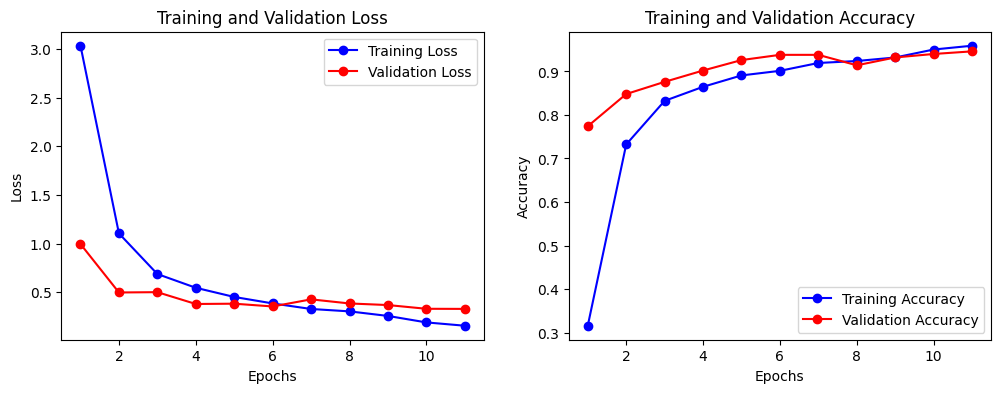

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# model = tf.keras.models.load_model("Checkpoint_P2.keras")

16/16 [==============================] - 2s 104ms/step - loss: 0.2804 - accuracy: 0.9300


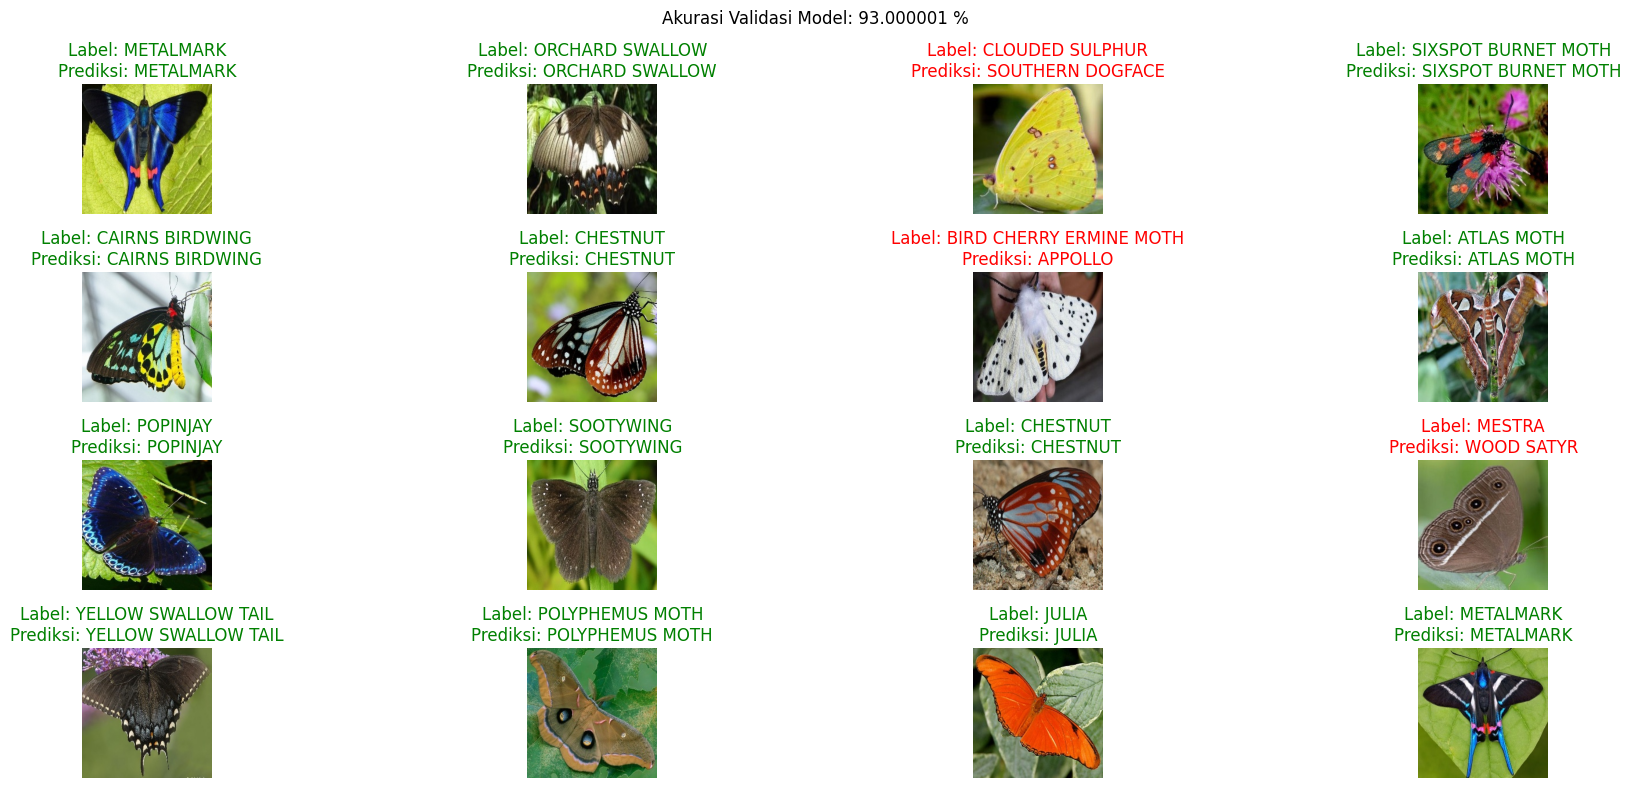

In [35]:
daftar_label = sorted(os.listdir("./Dataset/test"))

X_batch, y_batch = next(test_gen)
preds = model.predict(X_batch)
X_batch = (X_batch * 255).astype(np.uint8)

pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_batch, axis=1)

fig, axes = plt.subplots(4, 4, figsize=(20, 8))
test_loss, test_acc = model.evaluate(test_gen)
fig.suptitle("Akurasi Validasi Model: %f %%" % (test_acc * 100))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_batch[i])
    ax.axis('off')

    true_label = daftar_label[int(true_classes[i])]
    pred_label = daftar_label[int(pred_classes[i])]

    font_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"Label: {true_label}\nPrediksi: {pred_label}", color=font_color)

plt.tight_layout()
plt.show()


In [22]:
print(len(daftar_label))

100


In [26]:
test_gen.reset()

In [23]:
all_true_classes = []
all_pred_classes = []

for X_batch, y_batch in test_gen:
    preds = model.predict(X_batch)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_batch, axis=1)
    
    all_true_classes.extend(true_classes)
    all_pred_classes.extend(pred_classes)

    if len(all_true_classes)==500:
        break
    
cm = confusion_matrix(all_true_classes, all_pred_classes)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 0s 45ms/step
Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


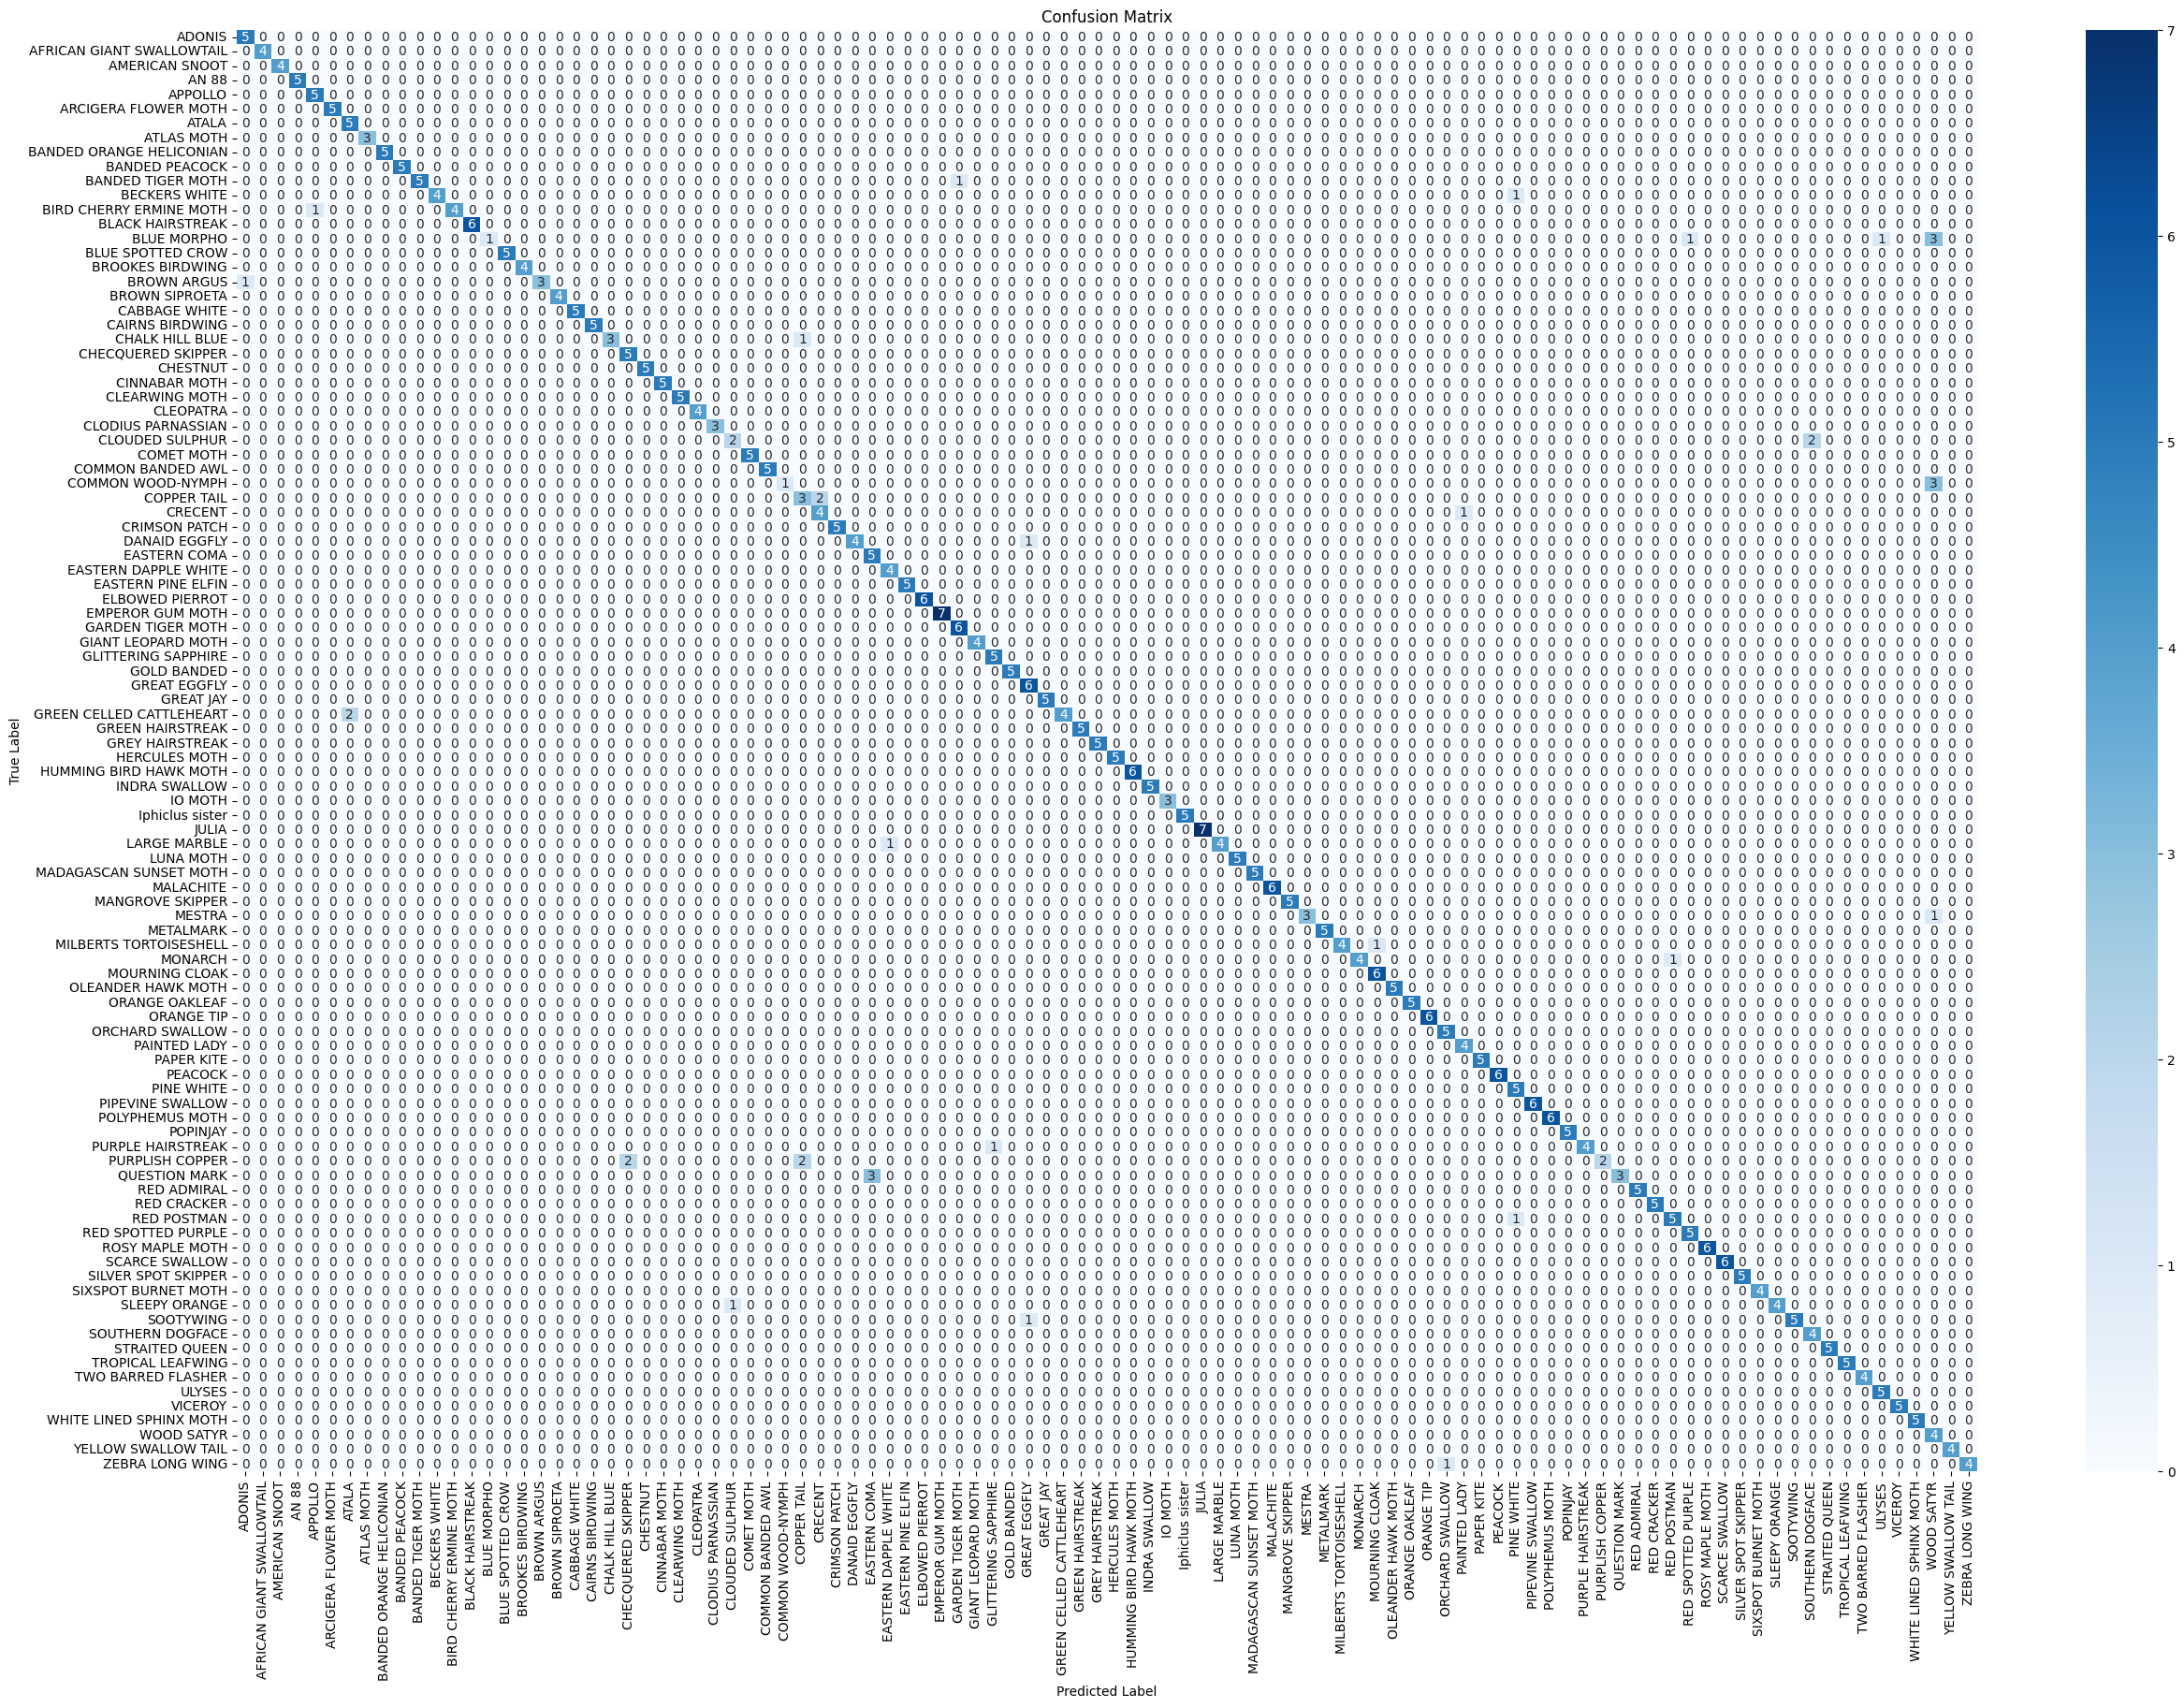

In [24]:
plt.figure(figsize=(30, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=daftar_label, yticklabels=daftar_label)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
report = classification_report(all_true_classes, all_pred_classes, target_names=daftar_label)
print("Classification Report:")
print(report)

Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       0.83      1.00      0.91         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         4
           AMERICAN SNOOT       1.00      1.00      1.00         4
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.83      1.00      0.91         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       0.71      1.00      0.83         5
               ATLAS MOTH       1.00      1.00      1.00         3
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.83      0.91         6
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.89         5
         BLACK HAIRSTREAK       1.00  